In [1]:
import pickle
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

In [2]:
complaints = pd.read_pickle('../data/complaints_df.pkl')
complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353432 entries, 0 to 353431
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   complaint        353432 non-null  object 
 1   category         353432 non-null  object 
 2   word_count       353432 non-null  int64  
 3   char_count       353432 non-null  int64  
 4   avg_word_len     353432 non-null  float64
 5   complaint_clean  353432 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 16.2+ MB


Following along with this example: https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [3]:
complaints['category_id'] = complaints['category'].factorize()[0]

In [4]:
category_id_df = complaints[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

In [5]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=1500, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(complaints['complaint_clean']).toarray()
labels = complaints['category_id']
features.shape

(353432, 2938)

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(category))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(complaints['complaint_clean'], complaints['category'], stratify=y, random_state = 369)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

complaint_text = X_test.iloc[50]

print(clf.predict(count_vect.transform([complaint_text])))

y_test.iloc[50]

In [6]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=369),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=369, max_iter=1000),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

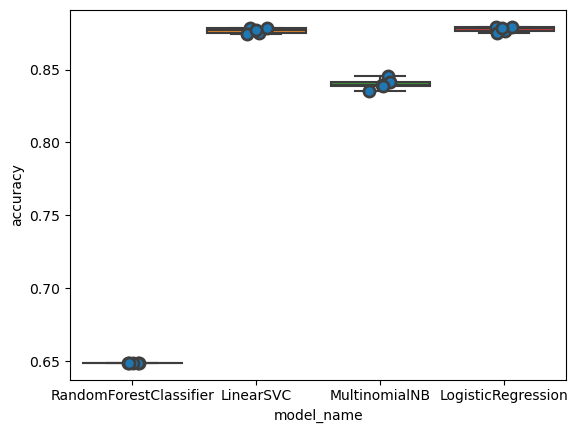

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [9]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.876664
LogisticRegression        0.877739
MultinomialNB             0.840077
RandomForestClassifier    0.648795
Name: accuracy, dtype: float64

In [11]:
model = LogisticRegression(random_state=369, max_iter=1000)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, 
                                                                                 labels, 
                                                                                 complaints.index, 
                                                                                 test_size=0.2,
                                                                                 random_state=369)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

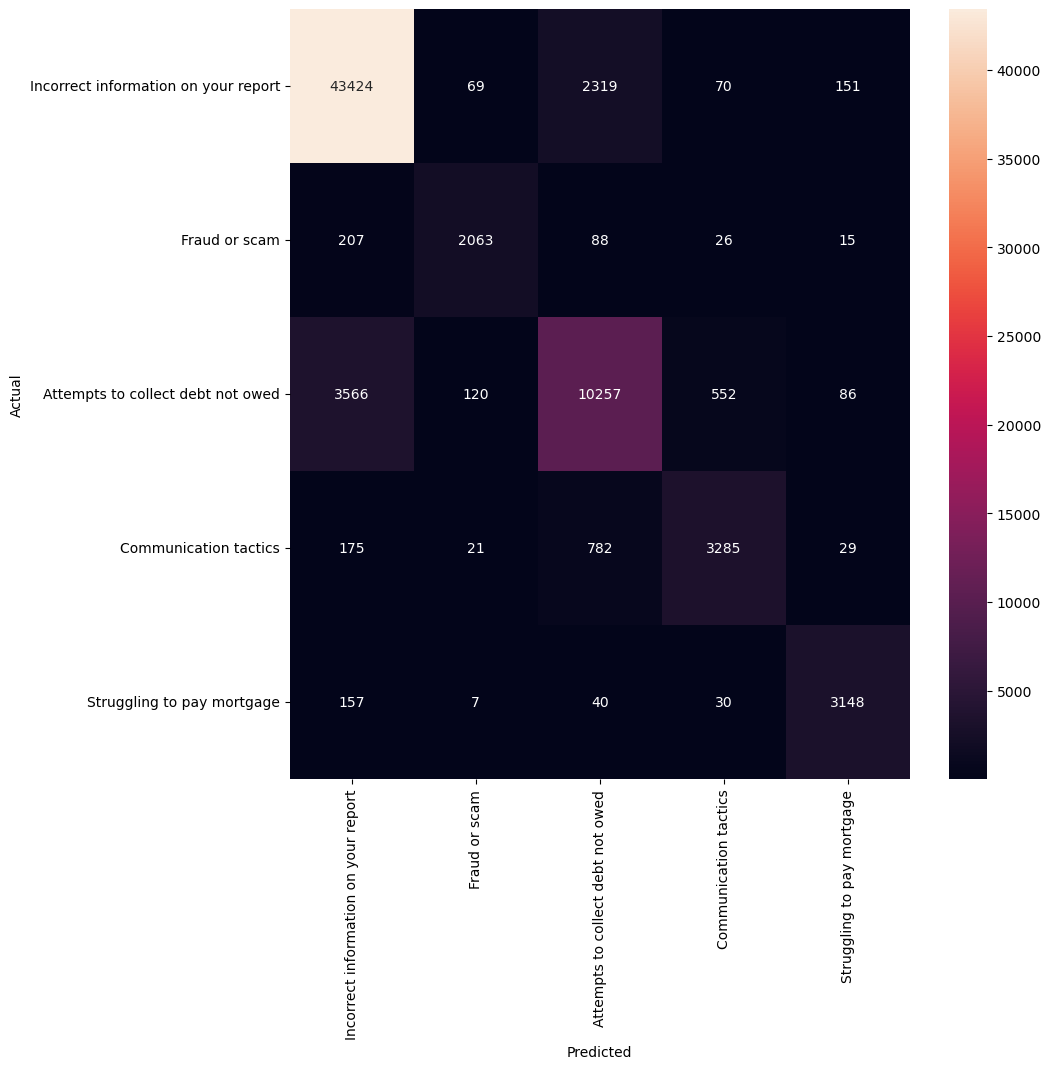

In [13]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [21]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8796101121847015

In [14]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=complaints['category'].unique()))

                                      precision    recall  f1-score   support

Incorrect information on your report       0.91      0.94      0.93     46033
                       Fraud or scam       0.90      0.86      0.88      2399
   Attempts to collect debt not owed       0.76      0.70      0.73     14581
               Communication tactics       0.83      0.77      0.80      4292
          Struggling to pay mortgage       0.92      0.93      0.92      3382

                            accuracy                           0.88     70687
                           macro avg       0.87      0.84      0.85     70687
                        weighted avg       0.88      0.88      0.88     70687

